In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[10]').appName('house_hunting').getOrCreate()

# load the data
data = spark.read.format("CSV").option("header","true").csv("/project/cmsc25025/zillow/zillow-train.csv")
test =  spark.read.format("CSV").option("header","true").csv("/project/cmsc25025/zillow/zillow-test.csv")

In [3]:
renov = list(set(data.select('MajorRenov').rdd.map(lambda x: x[0]).collect()))
msa = list(set(data.select('MSA').rdd.map(lambda x: x[0]).collect()))
city = list(set(data.select('City').rdd.map(lambda x: x[0]).collect()))
highschool = list(set(data.select('HighSchool').rdd.map(lambda x: x[0]).collect()))

print "Number of values for categories variables:"
print "MajorRenov - %d " % len(renov)
print "MSA - %d " % len(msa)
print "City - %d " % len(city)
print "HighSchool - %d " % len(highschool)

Number of values for categories variables:
MajorRenov - 118 
MSA - 4 
City - 1344 
HighSchool - 774 


In [4]:
encoded_renov = [0]*len(renov)
for i,val in enumerate(renov):
    if val == "NONE":
        encoded_renov[i] = 0
    else:
        tmp = int(val)
        if tmp <= 1900:
            encoded_renov[i] = 1
        elif tmp <= 1925 and tmp > 1900:
            encoded_renov[i] = 2
        elif tmp <= 1950 and tmp > 1925:
            encoded_renov[i] = 3
        elif tmp <= 1975 and tmp > 1950:
            encoded_renov[i] = 4
        elif tmp <= 2000 and tmp > 1975:
            encoded_renov[i] = 5
        else:
            encoded_renov[i] = 6

Numerical variables
ID histogram


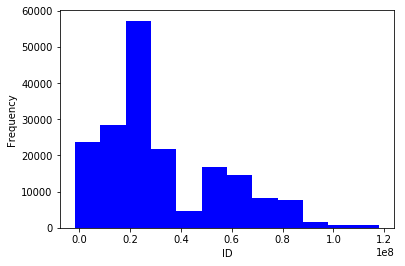

ListPrice histogram


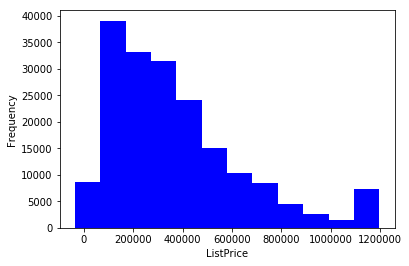

SaleYear histogram


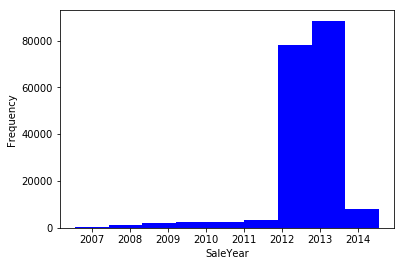

Bathroom histogram


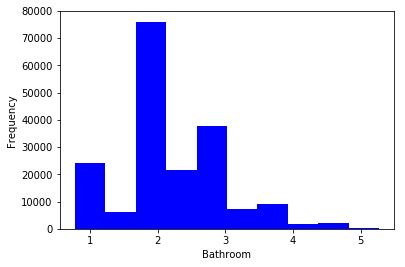

Bedroom histogram


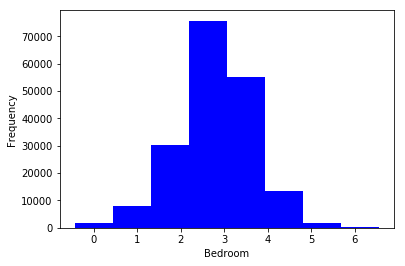

BuiltYear histogram


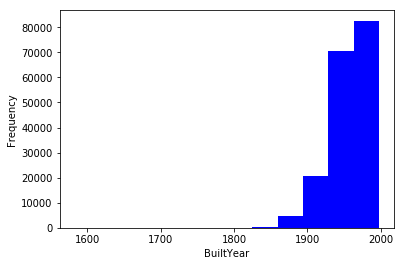

BuildDecade histogram


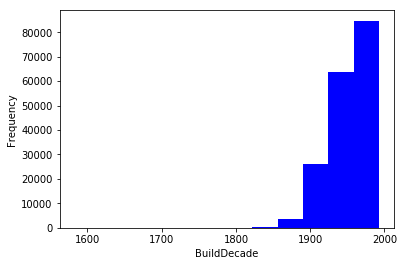

FinishSqFt histogram


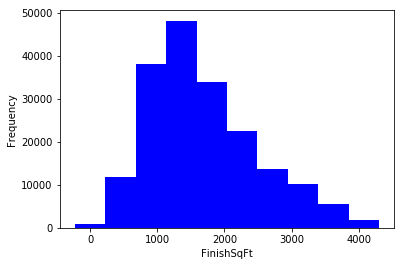

LotSqFt histogram


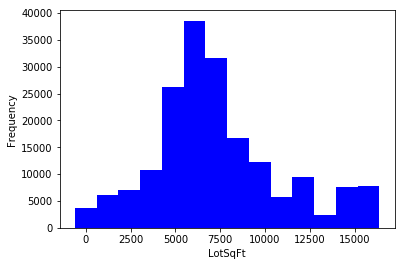

SalePrice histogram


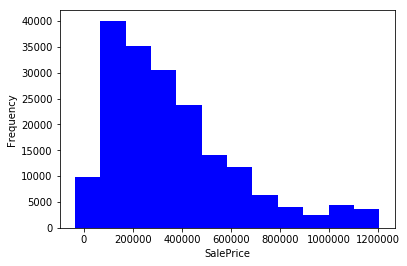



Lat/Long distribution


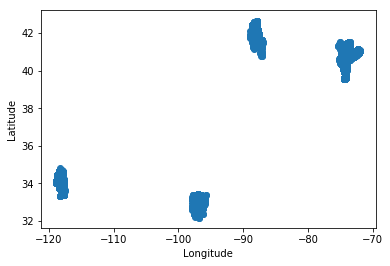

Categorical variables
MajorRenov histogram


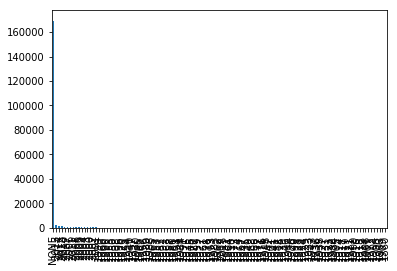

MSA histogram


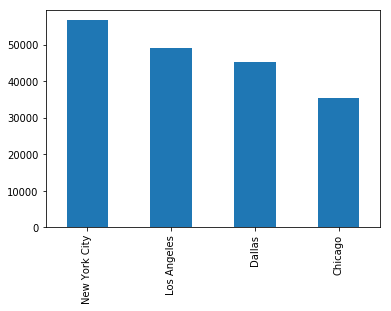

City histogram


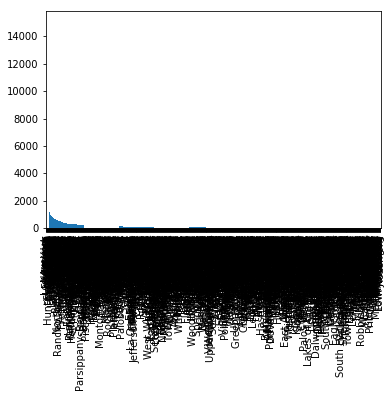

HighSchool histogram


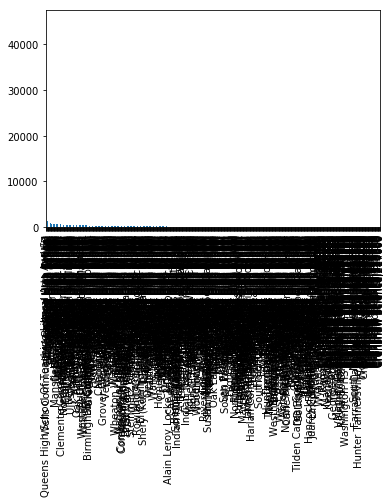

In [7]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# plot distributions of all variables
numerical_columns = ['ID','ListPrice','SaleYear','Bathroom','Bedroom','BuiltYear',\
           'BuildDecade','FinishSqFt','LotSqFt','SalePrice']
bin_size = [12,12,9,10,8,12,12,10,14,12]
categorical_columns = ['MajorRenov', 'MSA', 'City', 'HighSchool']

def create_hist(rdd_histogram_data):
    heights = np.array(rdd_histogram_data[1])
    full_bins = rdd_histogram_data[0]
    mid_point_bins = full_bins[:-1]
    widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
    plt.figure()
    plt.bar(mid_point_bins, heights, width=widths, color='b')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

print "Numerical variables"
for i,variable in enumerate(numerical_columns):
    print variable + " histogram"
    hist_data = data.select(variable).rdd.filter(lambda x: x[0] != 'NA' and x[0] != 'UNKNOWN' and x[0] is not None).map(lambda x: float(x[0])).histogram(bin_size[i])
    create_hist(hist_data)
print "\n"

print "Lat/Long distribution"
coord = data.rdd.map(lambda x: (x['Long'],x['Lat'])).collect()
plt.figure()
plt.scatter([x[0] for x in coord],[x[1] for x in coord])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

print "Categorical variables"
pdf = data.toPandas()
for variable in categorical_columns:
    print variable + " histogram"
    plt.figure()
    if variable == 'MajorRenov':
        pdf.MajorRenov.value_counts().plot(kind='bar')
    elif variable == 'MSA':
        pdf.MSA.value_counts().plot(kind='bar')
    elif variable == 'City':
        pdf.City.value_counts().plot(kind='bar')
    else:
        pdf.HighSchool.value_counts().plot(kind='bar')
    plt.show()
print "\n"

The number of values for each of the categorical variables is shown above. We see from the Longitude versus Latitude plot and MSA histogram that the data comes from 4 major areas - New York City, Los Angeles, Dallas, and Chicago. MajorRenov either takes the value NONE (the most common value by far) or the year of the renovation. Consequently, we decided to treat this variable as categorical, where NONE is its own category and other values are grouped in 25-year periods. Originally, I tried grouping in 50-year periods (5 categories total) but found 25-year periods (7 categories total) improved performance. Both City and HighSchool, more specific than MSA, have a large amount of categories and as such are ignored when training the random forest. MSA is also ignored because there are so few categories and this information is somewhat redundant to Longitude and Latitude. ID is also ignored.

Some notes for the numerical variables. Most of the data comes from more recent sales in 2012-2014. The number of bedrooms appears to have a normal-like distribution. List price and sale price distributions are relatively similar, with the most common value around 200,000 then generally decreasing.

Any missing values were treated as -1.


In [8]:
from pyspark.mllib.regression import LabeledPoint

def parse(line):

    categorical = [9,12,13,14]
    
    for i in range(len(line)):
        if i in categorical:
            if i == 9:
                line[i] = encoded_renov[renov.index(line[i])]
            elif i == 12:
                line[i] = msa.index(line[i])
        else:    
            if line[i] == 'NA' or line[i] == 'UNKNOWN' or line[i] is None:
                line[i] = -1 # mark missing values
            else:
                line[i] = float(line[i])
                
    # ignore ID, city, high school
    return LabeledPoint(line[15],line[1:13])

labeled_data = data.rdd.filter(lambda x: x['SalePrice'] != 'NA' and x['SalePrice'] != 'UNKNOWN' and x['SalePrice'] is not None).map(lambda x: parse(list(x)))
labeled_test = test.rdd.map(lambda x: parse(list(x)))

In [6]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

trainingData, testData = labeled_data.randomSplit([0.7, 0.3])
ntrees = [5,10,20]
depth = [5,10,20]
catFeatInfo = {8:7,11:4}

for n in ntrees:
    for d in depth:
        model = RandomForest.trainRegressor(trainingData,categoricalFeaturesInfo=catFeatInfo,\
                                            numTrees=n, featureSubsetStrategy='auto', \
                                            impurity='variance', maxDepth=d, maxBins = 32)
        predictions = model.predict(testData.map(lambda x: x.features))
        labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
        error = labelsAndPredictions.map(lambda (v, p): abs(v - p) / float(v)).sum() / float(testData.count())
        print '%d trees, %d depth' % (n,d)
        print 'Absolute relative error = ' + str(error)

----featureSubsetStrategy = auto, 5 categories for MajorRenov (every 50 years)----

5 trees, 5 depth - Absolute relative error = 0.127010973591

5 trees, 10 depth - Absolute relative error = 0.0601366897226

5 trees, 20 depth - Absolute relative error = 0.0421833801675

10 trees, 5 depth - Absolute relative error = 0.169759111527

10 trees, 10 depth - Absolute relative error = 0.0522917939733

10 trees, 20 depth - Absolute relative error = 0.037247692944

20 trees, 5 depth - Absolute relative error = 0.164501246277

20 trees, 10 depth - Absolute relative error = 0.0526174601814

20 trees, 20 depth - Absolute relative error = 0.037234278536

----featureSubsetStrategy = auto (sqrt), 7 categories for MajorRenov (every 50 years)----

20 trees, 20 depth - Absolute relative error = 0.0356190922299

----featureSubsetStrategy = log2, 7 categories for MajorRenov (every 50 years)----

20 trees, 20 depth - Absolute relative error = 0.0376165185308

----featureSubsetStrategy = onethird, 7 categories for MajorRenov (every 50 years)----

20 trees, 20 depth - Absolute relative error = 0.0366228598431

We found that increasing the depth (limited to 30 by pyspark's Decision Tree implementation) lowers the absolute relative error. A deep decision tree has low bias, so it makes sense that this decreases the error. Adding more trees also lowers the absolute relative error, though not to as large of a degree as increasing the depth. Note the only small difference in error between 10 trees with a depth of 20 and 20 trees with a depth of 20. Adding more trees decreases the variance, so it makes sense that more trees decreases the error. We also tried different feature subset strategies and found that auto (or sqrt) was better than both log2 and onethird.

In [10]:
# best parameters (from results above)
from pyspark.mllib.tree import RandomForest
best_n = 20 
best_d = 20
catFeatInfo = {8:7,11:4}
strategy = 'auto'

model = RandomForest.trainRegressor(labeled_data,categoricalFeaturesInfo=catFeatInfo, \
                                        numTrees=best_n, featureSubsetStrategy=strategy, \
                                        impurity='variance', maxDepth=best_d, maxBins=32)


In [11]:
def parse_test(line):

    categorical = [9,12,13,14]
    
    for i in range(len(line)-1):
        if i in categorical:
            if i == 9:
                if line[i] == "NONE":
                    line[i] = 0
                else:
                    tmp = int(line[i])
                    if tmp <= 1900:
                        line[i] = 1
                    elif tmp <= 1925 and tmp > 1900:
                        line[i] = 2
                    elif tmp <= 1950 and tmp > 1925:
                        line[i] = 3
                    elif tmp <= 1975 and tmp > 1950:
                        line[i] = 4
                    elif tmp <= 2000 and tmp > 1975:
                        line[i] = 5
                    else:
                        line[i] = 6
            elif i == 12:
                line[i] = msa.index(line[i])
        else:    
            if line[i] == 'NA' or line[i] == 'UNKNOWN' or line[i] is None:
                line[i] = -1 # mark missing values
            else:
                line[i] = float(line[i])
                
    # ignore ID, city, high school
    return line[1:13] # just the features

labeled_test = test.rdd.map(lambda x: parse_test(list(x)))
predictions = model.predict(labeled_test).collect()

In [12]:
columns = ['ID', 'Lat', 'Long', 'ListPrice', 'SaleYear', 'Bathroom', 'Bedroom', 'BuiltYear',\
           'BuildDecade', 'MajorRenov', 'FinishSqFt', 'LotSqFt', 'MSA', 'City', 'HighSchool', 'SalePrice']

def addSalePrice(row,i):
    row[15] = u'%f' % predictions[i]
    return row

test_predict = test.rdd.zipWithIndex().map(lambda (key,index): addSalePrice(list(key),index)).toDF(columns)
test_predict.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("TMP.csv")